In [199]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from functions import *

In [200]:
df_redshift_data_all = pd.read_csv('redshift_data.csv')


In [201]:
df_redshift_data_all['score_difference'] = df_redshift_data_all['home_score'] - df_redshift_data_all['away_score']

# Remove outliers based on the 'score_difference' column
z_scores = np.abs(stats.zscore(df_redshift_data_all['score_difference']))
df_redshift_data_all = df_redshift_data_all[z_scores < 3]
df_redshift_data_all.shape

(1054, 22)

In [202]:
# Define the features and target variable
X = df_redshift_data_all[[ 'total_linebreaks', 'total_tries', 'total_defenders_beaten',
                'total_jackals_success', 'total_intercepts', 'total_tackles_made', 'total_tackles_missed',
                'total_carry_metres',
                'total_turnovers_conceded', 'total_penalties_conceded']]
y = df_redshift_data_all['won_lost']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [203]:
rf_model = RandomForestClassifier(n_estimators=100)
rf, accuracy_rf, conf_matrix_rf, feature_importance_rf = train_evaluate_model(rf_model, X_train_scaled, y_train, X_test_scaled, y_test, feature_names=X.columns)
print("Random Forest Accuracy:", accuracy_rf)
print(feature_importance_rf)

Feature importance found
Random Forest Accuracy: 0.7914691943127962
                    feature  importance
0          total_linebreaks    0.085951
1               total_tries    0.216243
2    total_defenders_beaten    0.086824
3     total_jackals_success    0.067352
4          total_intercepts    0.022796
5        total_tackles_made    0.095452
6      total_tackles_missed    0.116022
7        total_carry_metres    0.125692
8  total_turnovers_conceded    0.102414
9  total_penalties_conceded    0.081253


In [204]:
# Logistic Regression
lr_model = LogisticRegression()
lr, accuracy_lr, conf_matrix_lr, feature_importance_lr = train_evaluate_model(lr_model, X_train_scaled, y_train, X_test_scaled, y_test, feature_names=X.columns)
print("Logistic Regression Accuracy:", accuracy_lr)
print(feature_importance_lr.head(15))

Coef found
Logistic Regression Accuracy: 0.7867298578199052
                    feature      coef
0          total_linebreaks  0.298547
1               total_tries  1.461161
2    total_defenders_beaten -0.157452
3     total_jackals_success  0.465272
4          total_intercepts  0.136346
5        total_tackles_made  0.149566
6      total_tackles_missed -0.695150
7        total_carry_metres  0.148045
8  total_turnovers_conceded -0.606407
9  total_penalties_conceded -0.419221


In [205]:
import xgboost as xgb# Initialize XGBoost classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb_classifier.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = xgb_classifier.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print("XGBClassifier Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

# Feature importance
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': xgb_classifier.feature_importances_})
print("Feature Importance:\n", feature_importance.sort_values(by='importance', ascending=False))

XGBClassifier Accuracy: 0.7914691943127962
Confusion Matrix:
 [[81 24]
 [20 86]]
Feature Importance:
                     feature  importance
1               total_tries    0.380696
8  total_turnovers_conceded    0.087693
9  total_penalties_conceded    0.085765
3     total_jackals_success    0.082251
6      total_tackles_missed    0.077421
0          total_linebreaks    0.068318
2    total_defenders_beaten    0.057555
7        total_carry_metres    0.055341
4          total_intercepts    0.052998
5        total_tackles_made    0.051962


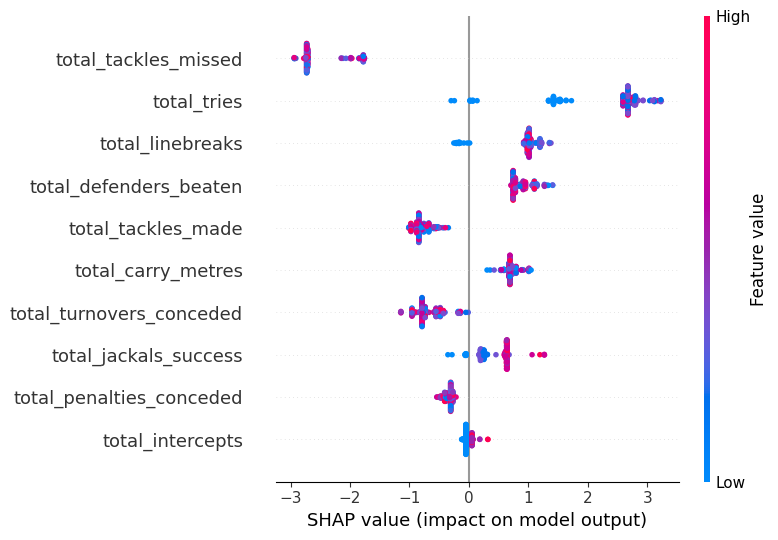

Mean SHAP values for each feature:
total_linebreaks: 0.9461
total_tries: 2.4100
total_defenders_beaten: 0.8703
total_jackals_success: 0.4527
total_intercepts: -0.0187
total_tackles_made: -0.7987
total_tackles_missed: -2.5472
total_carry_metres: 0.7137
total_turnovers_conceded: -0.6694
total_penalties_conceded: -0.3493


In [206]:
# Create the SHAP Explainer
explainer = shap.Explainer(xgb_classifier)

# Calculate SHAP values for test set
shap_values = explainer(X_test)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_test)

mean_shap_values = np.mean(shap_values.values, axis=0)
mean_shap_per_feature = dict(zip(X_test.columns, mean_shap_values))
print("Mean SHAP values for each feature:")
for feature, mean_shap in mean_shap_per_feature.items():
    print(f"{feature}: {mean_shap:.4f}")

In [207]:
# SVM with a linear kernel
svm_model = SVC(kernel='linear')
svm, accuracy_svm, conf_matrix_svm, feature_importance_svm = train_evaluate_model(svm_model, X_train_scaled, y_train, X_test_scaled, y_test, feature_names=X.columns)

# # MLP Neural Network
# mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300)
# mlp, accuracy_mlp, conf_matrix_mlp, _ = train_evaluate_model(mlp_model, X_train_scaled, y_train, X_test_scaled, y_test)
 
print("SVM Accuracy:", accuracy_svm)
print(feature_importance_svm)
# print("MLP Neural Network Accuracy:", accuracy_mlp)
# print( _ )

Coef found
SVM Accuracy: 0.7819905213270142
                    feature      coef
0          total_linebreaks  0.231895
1               total_tries  1.316843
2    total_defenders_beaten -0.157228
3     total_jackals_success  0.392425
4          total_intercepts  0.170481
5        total_tackles_made  0.111536
6      total_tackles_missed -0.570062
7        total_carry_metres  0.099245
8  total_turnovers_conceded -0.514797
9  total_penalties_conceded -0.304594
